# UNet on MNIST from Scratch

This notebook implements a classic UNet architecture in PyTorch and adapts it for MNIST digit classification.  
UNet is typically used for segmentation, but here we use its encoder-decoder structure to extract features and classify digits.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Load MNIST dataset
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256)

100%|██████████| 9.91M/9.91M [00:24<00:00, 397kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 99.7kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 538kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.98MB/s]


In [6]:
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

def crop_img(tensor, target_tensor):
    # Crop tensor to match target_tensor's spatial size
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    if delta == 0:
        return tensor
    start = delta // 2
    end = start + target_size
    return tensor[:, :, start:end, start:end]

class UNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)

        # Instead of segmentation output, use GAP + FC for classification
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, image):
        # Encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # Decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))

        

        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))

        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))

        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))

        # Classification head
        x = self.gap(x)  # (B, 64, 1, 1)
        x = x.view(x.size(0), -1)  # (B, 64)
        x = self.fc(x)  # (B, num_classes)
        return x

In [7]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("Using device:", device)

Using device: mps


In [8]:
model = UNet(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_accs = []

for epoch in range(3):  # Train for a few epochs
    model.train()
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = model(img)
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)
    print(f"Epoch {epoch}: Val Acc = {val_acc*100:.2f}%")

Epoch 0: Val Acc = 96.97%
Epoch 1: Val Acc = 98.66%
Epoch 2: Val Acc = 98.52%


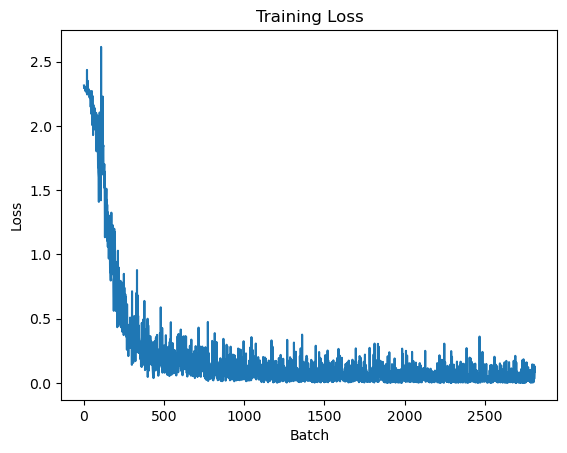

Final Validation Accuracy: 0.9852


In [9]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

print("Final Validation Accuracy:", val_accs[-1])

## Summary

- We implemented a classic UNet architecture from scratch and adapted it for MNIST digit classification.
- Instead of segmentation, we use UNet’s encoder-decoder to extract features and classify digits via a global average pooling and a linear layer.
- The model trains efficiently on Mac (MPS), CUDA, or CPU.